In [1]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors


In [2]:
!pip install google-auth-oauthlib google-api-python-client


^C


In [3]:
# Path to your client secret JSON file
CLIENT_SECRETS_FILE = "client_secret.json"

# The scopes required to access Fit data
SCOPES = ["https://www.googleapis.com/auth/fitness.activity.read",
          "https://www.googleapis.com/auth/fitness.location.read",
          "https://www.googleapis.com/auth/fitness.body.read"]

# API version
API_SERVICE_NAME = 'fitness'
API_VERSION = 'v1'

In [4]:
# Authentication flow
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    CLIENT_SECRETS_FILE, SCOPES)
credentials = flow.run_local_server(port=0)

# Build the API service
service = googleapiclient.discovery.build(
    API_SERVICE_NAME, API_VERSION, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1036982817354-keqo0ru9s40okkvm8pi8jisnu26e61lr.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A57393%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.activity.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.location.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.body.read&state=sTJZ5HzSXIDqVtgkdECiN3rKq55Tbq&access_type=offline


In [5]:
# Example: Fetch steps data for the last 7 days
from datetime import datetime, timedelta, timezone

# Use timezone-aware datetime object
now = datetime.now(timezone.utc)
start_time = int((now - timedelta(days=7)).timestamp() * 1000)
end_time = int(now.timestamp() * 1000)

dataset = f"{start_time}-{end_time}"

# Request step data
response = service.users().dataset().aggregate(userId="me", body={
    "aggregateBy": [{
        "dataTypeName": "com.google.step_count.delta"
    }],
    "bucketByTime": {"durationMillis": 86400000},  # Daily steps
    "startTimeMillis": start_time,
    "endTimeMillis": end_time
}).execute()

# Print the response
print(response)

{'bucket': [{'startTimeMillis': '1731660840542', 'endTimeMillis': '1731747240542', 'dataset': [{'dataSourceId': 'derived:com.google.step_count.delta:com.google.android.gms:aggregated', 'point': []}]}, {'startTimeMillis': '1731747240542', 'endTimeMillis': '1731833640542', 'dataset': [{'dataSourceId': 'derived:com.google.step_count.delta:com.google.android.gms:aggregated', 'point': []}]}, {'startTimeMillis': '1731833640542', 'endTimeMillis': '1731920040542', 'dataset': [{'dataSourceId': 'derived:com.google.step_count.delta:com.google.android.gms:aggregated', 'point': [{'startTimeNanos': '1731911075328379910', 'endTimeNanos': '1731919681987042985', 'dataTypeName': 'com.google.step_count.delta', 'originDataSourceId': 'raw:com.google.step_count.cumulative:OPPO:CPH1803:610f3d48:Step Counter', 'value': [{'intVal': 393, 'mapVal': []}]}]}]}, {'startTimeMillis': '1731920040542', 'endTimeMillis': '1732006440542', 'dataset': [{'dataSourceId': 'derived:com.google.step_count.delta:com.google.android

for bucket in response.get('bucket', []):
    steps = 0
    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)
    print(f"Steps on {bucket['startTimeMillis']} were: {steps}")

In [6]:
from datetime import datetime

for bucket in response.get('bucket', []):
    steps = 0
    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)
    
    # Convert the startTimeMillis to a human-readable date
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')
    
    print(f"Steps on {date} were: {steps}")
from datetime import datetime, timedelta, timezone

# Use timezone-aware datetime object
now = datetime.now(timezone.utc)
start_time = int((now - timedelta(days=7)).timestamp() * 1000)
end_time = int(now.timestamp() * 1000)


Steps on 2024-11-15 were: 0
Steps on 2024-11-16 were: 0
Steps on 2024-11-17 were: 393
Steps on 2024-11-18 were: 1170
Steps on 2024-11-19 were: 613
Steps on 2024-11-20 were: 1471
Steps on 2024-11-21 were: 687


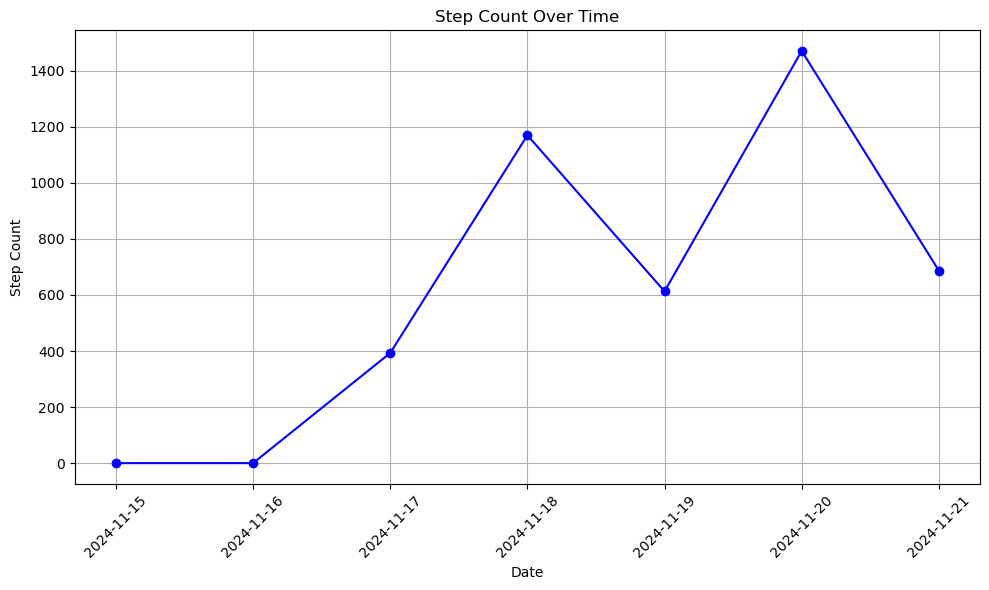

In [7]:
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta


# Extract dates and steps
dates = []
steps_counts = []

for bucket in response.get('bucket', []):
    steps = 0
    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)
    
    # Convert the startTimeMillis to a human-readable date
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')
    
    dates.append(date)
    steps_counts.append(steps)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dates, steps_counts, marker='o', linestyle='-', color='b')
plt.title('Step Count Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


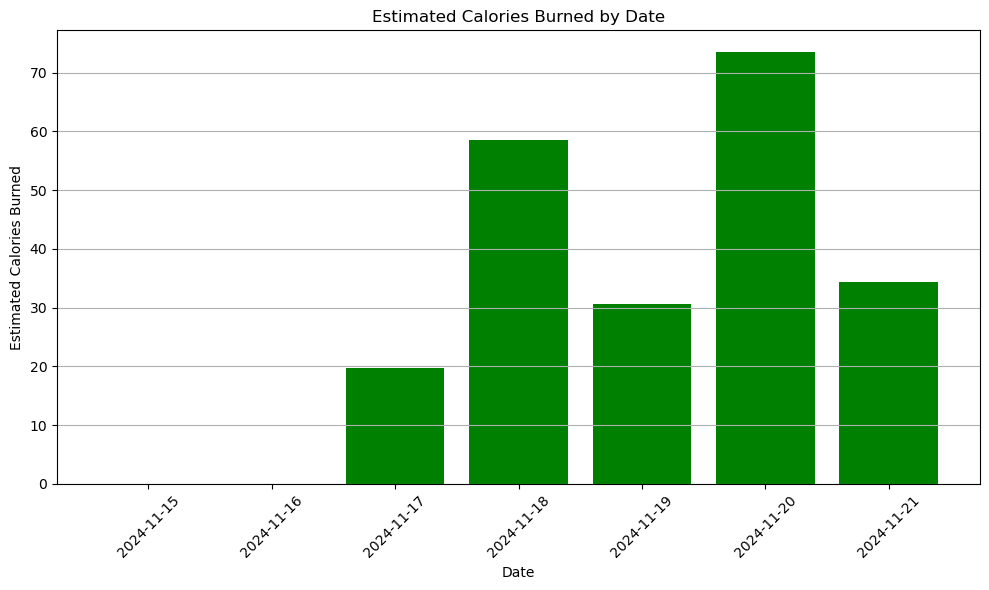

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

# Constants for calories burned estimation
calories_per_step = 0.05  # Average calories burned per step

# Extract steps data, calculate estimated calories burned, and map to dates
dates = []
total_calories_per_date = {}

for bucket in response.get('bucket', []):
    steps = 0
    # Convert startTimeMillis to a human-readable date
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')
    
    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)
    
    # Calculate estimated calories burned
    estimated_calories = steps * calories_per_step
    
    # Accumulate calories for the same date
    if date in total_calories_per_date:
        total_calories_per_date[date] += estimated_calories
    else:
        total_calories_per_date[date] = estimated_calories

# Prepare data for plotting
dates = list(total_calories_per_date.keys())
calories_burned = list(total_calories_per_date.values())

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(dates, calories_burned, color='green')
plt.title('Estimated Calories Burned by Date')
plt.xlabel('Date')
plt.ylabel('Estimated Calories Burned')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()


In [9]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [20]:
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime
import google_auth_oauthlib.flow
import googleapiclient.discovery
from datetime import datetime, timedelta, timezone

# Path to your client secret JSON file
CLIENT_SECRETS_FILE = "client_secret.json"

# The scopes required to access Fit data
SCOPES = [
    "https://www.googleapis.com/auth/fitness.activity.read",
    "https://www.googleapis.com/auth/fitness.location.read",
    "https://www.googleapis.com/auth/fitness.body.read"
]

# API version
API_SERVICE_NAME = 'fitness'
API_VERSION = 'v1'

# Authentication flow
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    CLIENT_SECRETS_FILE, SCOPES)
credentials = flow.run_local_server(port=0)

# Build the API service
service = googleapiclient.discovery.build(
    API_SERVICE_NAME, API_VERSION, credentials=credentials)

# Fetch steps data for the last 7 days
now = datetime.now(timezone.utc)
start_time = int((now - timedelta(days=7)).timestamp() * 1000)
end_time = int(now.timestamp() * 1000)

dataset = f"{start_time}-{end_time}"

# Request step data
response = service.users().dataset().aggregate(userId="me", body={
    "aggregateBy": [{
        "dataTypeName": "com.google.step_count.delta"
    }],
    "bucketByTime": {"durationMillis": 86400000},  # Daily steps
    "startTimeMillis": start_time,
    "endTimeMillis": end_time
}).execute()

# Initialize lists for plotting
dates = []
steps_counts = []
total_calories_per_date = {}
calories_per_step = 0.05  # Average calories burned per step

# Extract data for plotting
for bucket in response.get('bucket', []):
    steps = 0
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')

    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)
    
    # Calculate estimated calories burned
    estimated_calories = steps * calories_per_step
    
    # Store data for plotting
    dates.append(date)
    steps_counts.append(steps)
    
    # Accumulate calories for the same date
    total_calories_per_date[date] = total_calories_per_date.get(date, 0) + estimated_calories

# Prepare data for plotting calories
calories_burned = list(total_calories_per_date.values())

# Streamlit layout
st.title("Fitness Data Overview")

# Step Count Plot
st.header("Step Count Over Time")
plt.figure(figsize=(10, 6))
plt.plot(dates, steps_counts, marker='o', linestyle='-', color='b')
plt.title('Step Count Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.xticks(rotation=45)
plt.grid(True)
st.pyplot(plt)

# Calories Burned Plot
st.header("Estimated Calories Burned by Date")
plt.figure(figsize=(10, 6))
plt.bar(dates, calories_burned, color='green')
plt.title('Estimated Calories Burned by Date')
plt.xlabel('Date')
plt.ylabel('Estimated Calories Burned')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')
st.pyplot(plt)

# Run the app
if __name__ == '__main__':
    st.run()


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1036982817354-keqo0ru9s40okkvm8pi8jisnu26e61lr.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A56767%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.activity.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.location.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.body.read&state=VSrumVll9WgS4UII2W5XoCpiPOlDD9&access_type=offline


AttributeError: module 'streamlit' has no attribute 'run'

In [22]:
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import google_auth_oauthlib.flow
import googleapiclient.discovery

# Path to your client secret JSON file
CLIENT_SECRETS_FILE = "client_secret.json"

# The scopes required to access Fit data
SCOPES = [
    "https://www.googleapis.com/auth/fitness.activity.read",
    "https://www.googleapis.com/auth/fitness.location.read",
    "https://www.googleapis.com/auth/fitness.body.read"
]

# API version
API_SERVICE_NAME = 'fitness'
API_VERSION = 'v1'

# Authentication flow
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    CLIENT_SECRETS_FILE, SCOPES)
credentials = flow.run_local_server(port=0)

# Build the API service
service = googleapiclient.discovery.build(
    API_SERVICE_NAME, API_VERSION, credentials=credentials)

# Fetch steps data for the last 7 days
now = datetime.now(timezone.utc)
start_time = int((now - timedelta(days=7)).timestamp() * 1000)
end_time = int(now.timestamp() * 1000)

dataset = f"{start_time}-{end_time}"

# Request step data
response = service.users().dataset().aggregate(userId="me", body={
    "aggregateBy": [{
        "dataTypeName": "com.google.step_count.delta"
    }],
    "bucketByTime": {"durationMillis": 86400000},  # Daily steps
    "startTimeMillis": start_time,
    "endTimeMillis": end_time
}).execute()

# Initialize lists for plotting
dates = []
steps_counts = []
total_calories_per_date = {}
calories_per_step = 0.05  # Average calories burned per step

# Extract data for plotting
for bucket in response.get('bucket', []):
    steps = 0
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')

    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)

    # Calculate estimated calories burned
    estimated_calories = steps * calories_per_step

    # Store data for plotting
    dates.append(date)
    steps_counts.append(steps)

    # Accumulate calories for the same date
    total_calories_per_date[date] = total_calories_per_date.get(date, 0) + estimated_calories

# Prepare data for plotting calories
calories_burned = list(total_calories_per_date.values())

# Streamlit layout
st.title("Fitness Data Overview")

# Step Count Plot
st.header("Step Count Over Time")
plt.figure(figsize=(10, 6))
plt.plot(dates, steps_counts, marker='o', linestyle='-', color='b')
plt.title('Step Count Over Time')
plt.xlabel('Date')
plt.ylabel('Step Count')
plt.xticks(rotation=45)
plt.grid(True)
st.pyplot(plt)

# Calories Burned Plot
st.header("Estimated Calories Burned by Date")
plt.figure(figsize=(10, 6))
plt.bar(dates, calories_burned, color='green')
plt.title('Estimated Calories Burned by Date')
plt.xlabel('Date')
plt.ylabel('Estimated Calories Burned')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')
st.pyplot(plt)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1036982817354-keqo0ru9s40okkvm8pi8jisnu26e61lr.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A56878%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.activity.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.location.read+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.body.read&state=mBYZnSDs3qLXMJZz9G0MASlqCpnzSC&access_type=offline


DeltaGenerator()

In [23]:
streamlit run fitness_dashboard.py


SyntaxError: invalid syntax (2153904786.py, line 1)

In [21]:
streamlit run GFit.py

SyntaxError: invalid syntax (450566633.py, line 1)

In [19]:
!pip install streamlit

In [24]:
!pip install streamlit
!pip install jupyter-streamlit


ERROR: Could not find a version that satisfies the requirement jupyter-streamlit (from versions: none)
ERROR: No matching distribution found for jupyter-streamlit


In [25]:
%load_ext streamlit.notebook


ModuleNotFoundError: No module named 'streamlit.notebook'

In [11]:
%%writefile googlefit.py

import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
import google_auth_oauthlib.flow
import googleapiclient.discovery

# Path to your client secret JSON file
CLIENT_SECRETS_FILE = "client_secret.json"

# The scopes required to access Fit data
SCOPES = [
    "https://www.googleapis.com/auth/fitness.activity.read",
    "https://www.googleapis.com/auth/fitness.location.read",
    "https://www.googleapis.com/auth/fitness.body.read"
]

# API version
API_SERVICE_NAME = 'fitness'
API_VERSION = 'v1'

# Authentication flow
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(
    CLIENT_SECRETS_FILE, SCOPES)
credentials = flow.run_local_server(port=0)

# Build the API service
service = googleapiclient.discovery.build(
    API_SERVICE_NAME, API_VERSION, credentials=credentials)

# Fetch steps data for the last 7 days
now = datetime.now(timezone.utc)
start_time = int((now - timedelta(days=7)).timestamp() * 1000)
end_time = int(now.timestamp() * 1000)

dataset = f"{start_time}-{end_time}"

# Request step data
response = service.users().dataset().aggregate(userId="me", body={
    "aggregateBy": [{
        "dataTypeName": "com.google.step_count.delta"
    }],
    "bucketByTime": {"durationMillis": 86400000},  # Daily steps
    "startTimeMillis": start_time,
    "endTimeMillis": end_time
}).execute()

# Initialize lists for plotting
dates = []
steps_counts = []
total_calories_per_date = {}
calories_per_step = 0.05  # Average calories burned per step

# Extract data for plotting
for bucket in response.get('bucket', []):
    steps = 0
    start_time = int(bucket['startTimeMillis'])
    date = datetime.utcfromtimestamp(start_time / 1000).strftime('%Y-%m-%d')

    for dataset in bucket.get('dataset', []):
        for point in dataset.get('point', []):
            for value in point.get('value', []):
                steps += value.get('intVal', 0)

    # Calculate estimated calories burned
    estimated_calories = steps * calories_per_step

    # Store data for plotting
    dates.append(date)
    steps_counts.append(steps)

    # Accumulate calories for the same date
    total_calories_per_date[date] = total_calories_per_date.get(date, 0) + estimated_calories

# Prepare data for plotting calories
calories_burned = list(total_calories_per_date.values())

# Streamlit app layout
st.title("Fitness Data Overview")

# Step Count Plot
st.header("Step Count Over Time")
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dates, steps_counts, marker='o', linestyle='-', color='b')
ax.set_title('Step Count Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Step Count')
ax.grid(True)
st.pyplot(fig)

# Calories Burned Plot
st.header("Estimated Calories Burned by Date")
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(dates, calories_burned, color='green')
ax.set_title('Estimated Calories Burned by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Estimated Calories Burned')
ax.grid(axis='y')
st.pyplot(fig)


Writing googlefit.py


In [ ]:
!streamlit run streamlit_app.py